In [460]:
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from pickle import dump
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [461]:
# Loading data from SQLite to pandas

path_to_db = '/workspaces/mds8-final-project-bmh/data/raw/rentcast_FL.db'
conn = sqlite3.connect(path_to_db)
query = """SELECT * FROM properties"""
data = pd.read_sql(query, conn)
conn.close()
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,foundationType,garage,garageSpaces,garageType,pool,roomCount,unitCount,viewType
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,...,0,2.0,None,0,NaN,None,True,NaN,1.0,Water
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3.0,...,0,1.0,None,1,4.0,Garage,False,NaN,1.0,None
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None


In [462]:
data = data[data['yearBuilt'] <= 2025]

data['years_old'] = 2025 - data['yearBuilt']

In [463]:
# Changing the multiple ways to designate pool into 1/0

bool_mapper = {
    '1':1,
    '0':0,
    'True':1,
    'False':0,
    'Inground':1,
    'Type Unknown': 1,
    'Pool/spa':1
}

data['pool'] = data['pool'].map(bool_mapper).fillna(0).astype(int)

In [464]:
data.columns.tolist()

['id',
 'formattedAddress',
 'city',
 'state',
 'zipCode',
 'county',
 'latitude',
 'longitude',
 'propertyType',
 'bedrooms',
 'bathrooms',
 'squareFootage',
 'lotSize',
 'yearBuilt',
 'subdivision',
 'zoning',
 'lastSaleDate',
 'lastSalePrice',
 'hoa',
 'architectureType',
 'cooling',
 'coolingType',
 'heating',
 'heatingType',
 'exteriorType',
 'fireplace',
 'floorCount',
 'foundationType',
 'garage',
 'garageSpaces',
 'garageType',
 'pool',
 'roomCount',
 'unitCount',
 'viewType',
 'years_old']

In [465]:
cols = [
    # 'id',
    'formattedAddress',
    'city',
    # 'state',
    'zipCode',
    'county',
    'latitude',
    'longitude',
    'propertyType',
    'bedrooms',
    'bathrooms',
    'squareFootage',
    'lotSize',
    'yearBuilt',
    # 'subdivision',
    # 'zoning',
    # 'lastSaleDate',
    'lastSalePrice',
    # 'hoa',
    # 'architectureType',
    'cooling',
    # 'coolingType',
    # 'heating',
    # 'heatingType',
    # 'exteriorType',
    # 'fireplace',
    # 'floorCount',
    # 'foundationType',
    # 'garage',
    # 'garageSpaces',
    # 'garageType',
    'pool',
    # 'roomCount',
    # 'unitCount',
    # 'viewType',
    'years_old',
    ]

In [466]:
data = data[cols]
data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,pool,years_old
1,"5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,1.5,1022.0,7780.0,1979.0,469000.0,0,1,46.0
2,"1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,32254,Duval,30.339189,-81.717711,Single Family,3.0,1.0,1192.0,7155.0,1951.0,170000.0,1,0,74.0
3,"2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,33019,Broward,25.999305,-80.118487,Condo,2.0,2.0,865.0,951.0,1965.0,300000.0,0,0,60.0
4,"6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,2.0,1335.0,43560.0,1986.0,250000.0,0,0,39.0
5,"8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,33473,Palm Beach,26.493040,-80.183199,Single Family,3.0,2.5,2338.0,10171.0,2014.0,765000.0,1,1,11.0


In [467]:
data['cooling'].isna().any()

np.False_

In [468]:
data['propertyType'].unique()

array(['Townhouse', 'Single Family', 'Condo', 'Multi-Family', 'Land',
       'Manufactured', 'Apartment', None], dtype=object)

In [469]:
prop_types = [
    'Single Family', 
    'Townhouse', 
    'Condo', 
    # 'Multi-Family', 
    # 'Land',
    'Manufactured', 
    # 'Apartment',
]

In [470]:
data = data[data['propertyType'].isin(prop_types)]

In [471]:
data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,pool,years_old
1,"5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,1.5,1022.0,7780.0,1979.0,469000.0,0,1,46.0
2,"1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,32254,Duval,30.339189,-81.717711,Single Family,3.0,1.0,1192.0,7155.0,1951.0,170000.0,1,0,74.0
3,"2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,33019,Broward,25.999305,-80.118487,Condo,2.0,2.0,865.0,951.0,1965.0,300000.0,0,0,60.0
4,"6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,2.0,1335.0,43560.0,1986.0,250000.0,0,0,39.0
5,"8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,33473,Palm Beach,26.493040,-80.183199,Single Family,3.0,2.5,2338.0,10171.0,2014.0,765000.0,1,1,11.0


In [472]:
data.shape

(119951, 16)

In [473]:
data = data.dropna()
data.shape

(104275, 16)

In [474]:
data['lastSalePrice'].describe()

count    1.042750e+05
mean     5.441020e+05
std      1.594536e+06
min      3.100000e+02
25%      2.610000e+05
50%      3.720000e+05
75%      5.449000e+05
max      2.880000e+08
Name: lastSalePrice, dtype: float64

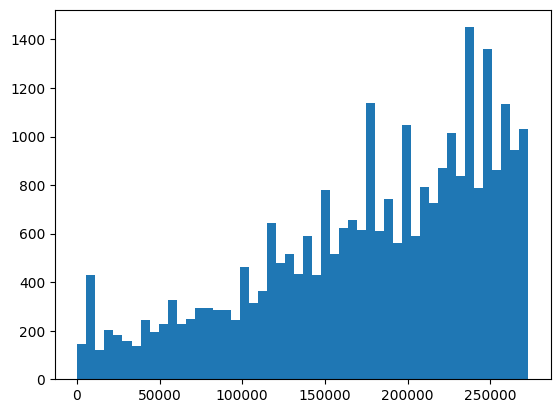

In [475]:
low_price = data[data['lastSalePrice'] < 273000]

plt.hist(low_price['lastSalePrice'], bins=50)
plt.show()

In [476]:
very_low = data[data['lastSalePrice'] < 50000]
very_low.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1821 entries, 17 to 145570
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  1821 non-null   object 
 1   city              1821 non-null   object 
 2   zipCode           1821 non-null   int64  
 3   county            1821 non-null   object 
 4   latitude          1821 non-null   float64
 5   longitude         1821 non-null   float64
 6   propertyType      1821 non-null   object 
 7   bedrooms          1821 non-null   float64
 8   bathrooms         1821 non-null   float64
 9   squareFootage     1821 non-null   float64
 10  lotSize           1821 non-null   float64
 11  yearBuilt         1821 non-null   float64
 12  lastSalePrice     1821 non-null   float64
 13  cooling           1821 non-null   int64  
 14  pool              1821 non-null   int64  
 15  years_old         1821 non-null   float64
dtypes: float64(9), int64(3), object(4)
memory us

In [477]:
very_low.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,pool,years_old
count,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1.821000e+03,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000
mean,33699.637562,28.415991,-82.117156,2.944536,1.923394,1492.589237,2.042734e+04,1998.895662,23997.536518,0.506864,0.046678,26.104338
std,851.538088,1.285413,1.239782,0.789143,0.554732,538.042704,1.240772e+05,27.721537,14315.205633,0.500090,0.211005,27.721537
min,32008.000000,25.092931,-87.433430,1.000000,0.500000,200.000000,2.180000e+02,1891.000000,310.000000,0.000000,0.000000,0.000000
25%,32908.000000,27.023195,-82.270858,2.000000,2.000000,1144.000000,7.500000e+03,1979.000000,10000.000000,0.000000,0.000000,1.000000
50%,33971.000000,28.898140,-82.010861,3.000000,2.000000,1472.000000,1.001900e+04,2005.000000,22600.000000,1.000000,0.000000,20.000000
75%,34470.000000,29.152025,-81.639347,3.000000,2.000000,1811.000000,1.335200e+04,2024.000000,38000.000000,1.000000,0.000000,46.000000
max,34997.000000,30.971297,-80.053292,6.000000,6.000000,6009.000000,3.746160e+06,2025.000000,49900.000000,1.000000,1.000000,134.000000


In [478]:
very_low[very_low['bedrooms'] == 6]

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,pool,years_old
1463,"1115 Joseph St, Jacksonville, FL 32206",Jacksonville,32206,Duval,30.346933,-81.640630,Single Family,6.0,2.0,1474.0,3541.0,1914.0,48900.0,1,0,111.0
91479,"1045 E 24th St, Jacksonville, FL 32206",Jacksonville,32206,Duval,30.359815,-81.641962,Single Family,6.0,3.5,1723.0,6970.0,1928.0,45000.0,1,0,97.0
124552,"2223 Carver Ave, Fort Myers, FL 33916",Fort Myers,33916,Lee,26.638425,-81.846618,Single Family,6.0,5.0,1832.0,5401.0,2024.0,47000.0,0,0,1.0
124559,"2219 Carver Ave, Fort Myers, FL 33916",Fort Myers,33916,Lee,26.638720,-81.846619,Single Family,6.0,5.0,2000.0,5358.0,2024.0,47000.0,0,0,1.0


These are either inaccurate or very old without renovations. May need to filter for both year built and price range.

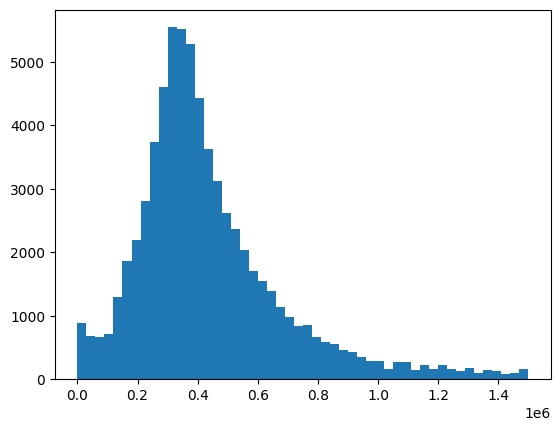

In [479]:
newer = data[data['yearBuilt'] >= 1980]

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 1_500_000))
plt.show()

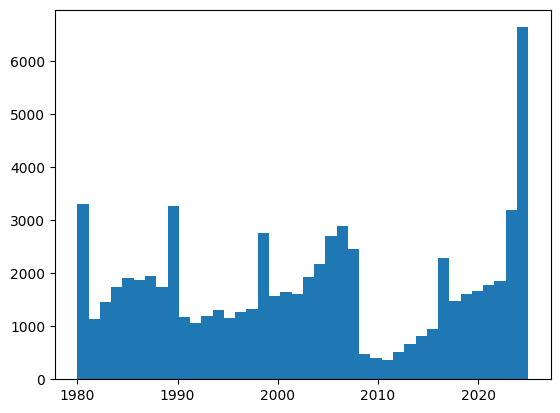

In [480]:
plt.hist(newer['yearBuilt'], bins=40)
plt.show()

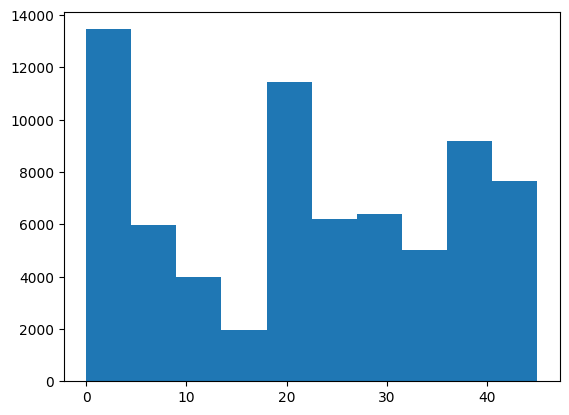

In [481]:
plt.hist(newer['years_old'])
plt.show()

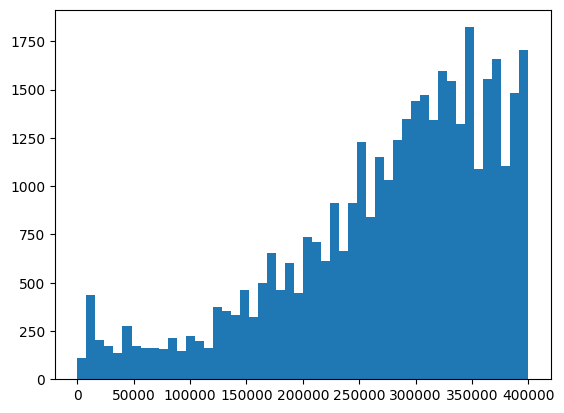

In [482]:
# Zooming in on that lower dip

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 400000))
plt.show()

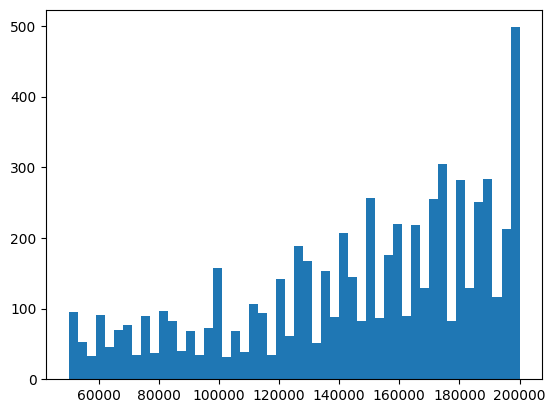

In [483]:
plt.hist(newer['lastSalePrice'], bins=50, range=(50000, 200000))
plt.show()

In [484]:
# filtering by price

filtered = newer[(newer['lastSalePrice'] > 100_000) & ((newer['lastSalePrice'] < 1_000_000))]

In [485]:
filtered.shape

(63209, 16)

In [486]:
filtered['county'].value_counts().head(10)

county
Lee             4677
Palm Beach      4437
Hillsborough    4290
Orange          3679
Polk            3516
Duval           3046
Pasco           2875
Broward         2468
Osceola         2263
Marion          2216
Name: count, dtype: int64

In [487]:
county_counts = filtered['county'].value_counts()
big_counties= county_counts[county_counts >= 2216].index

filtered = filtered[filtered['county'].isin(big_counties)]

filtered.shape

(33467, 16)

In [488]:
filtered = filtered.copy()
filtered['zipCode'] = filtered['zipCode'].astype(str)

In [489]:
num_var = [
    'latitude',
    'longitude',
    'bedrooms',
    'bathrooms',
    'squareFootage',
    'lotSize',
    # 'yearBuilt',
    # 'subdivision',
    # 'zoning',
    # 'lastSaleDate',
    'lastSalePrice',
    'years_old',
    'pool',
]

cat_var = [
    'city',
    'zipCode',
    'county',
    'propertyType',
]

In [490]:
# Getting dummies for cat_var

cat_data = pd.get_dummies(filtered[cat_var])

# Recreating the dataframe with the numerical and dummy columns 

filtered = pd.concat([filtered[num_var], cat_data], axis=1)

# # Getting columns for dummy variables

# cat_var = cat_data.columns.astype(str).tolist()

In [491]:
filtered.head()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,lastSalePrice,years_old,pool,city_Alva,...,county_Marion,county_Orange,county_Osceola,county_Palm Beach,county_Pasco,county_Polk,propertyType_Condo,propertyType_Manufactured,propertyType_Single Family,propertyType_Townhouse
4,26.556118,-80.137678,2.0,2.0,1335.0,43560.0,250000.0,39.0,0,False,...,False,False,False,True,False,False,True,False,False,False
5,26.493040,-80.183199,3.0,2.5,2338.0,10171.0,765000.0,11.0,1,False,...,False,False,False,True,False,False,False,False,True,False
6,28.238025,-82.444252,3.0,2.0,1579.0,6897.0,355000.0,15.0,0,False,...,False,False,False,False,True,False,False,False,True,False
9,26.566303,-81.882644,2.0,2.0,630.0,958.0,220000.0,44.0,0,False,...,False,False,False,False,False,False,False,False,True,False
15,27.899249,-82.352937,3.0,2.0,1880.0,3222.0,340000.0,7.0,0,False,...,False,False,False,False,False,False,False,False,True,False


In [492]:
# Features and target, splitting data

y = filtered['lastSalePrice']
X = filtered.drop(['lastSalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [493]:
X_train.shape

(26773, 539)

In [494]:
# XGBoost Regressor

xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 83928.68533275745
Coefficient of determination: 0.7833744565319749


In [495]:
# # XGBoost Regressor

# xgbr = XGBRegressor(subsample=0.8, reg_lambda=1, reg_alpha=0, n_estimators=200, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.8)
# xgbr.fit(X_train, y_train)

# y_pred = xgbr.predict(X_test)

# print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

In [496]:
filtered.shape

(33467, 540)

In [497]:
# # Optimizing model

# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.01, 0.1],
#     'reg_lambda': [1, 1.5, 2]
# }

# xgb = XGBRegressor(random_state=42)

# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_dist,
#     n_iter=10,            # Number of random combinations
#     scoring='neg_mean_squared_error',  # Change if classification
#     cv=3,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# print("Best params:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

# best_model = random_search.best_estimator_


Remaining questions:
- lot sizes --filter?
- condo lot sizes?
    - places that claim the size of the whole complex also charge more, possibly because of amenities?